## K Nearest Neighbors

The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. K-Nearest Neighbors (KNN) is one of the simplest algorithms used in Machine Learning for regression and classification problem. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.

In this notebook, we use the K Nearest Neighbors method to build a classifier to predict the __isPositive__ field of our review dataset (that is very similar to the final project dataset).


1. <a href="#1">Load the dataset</a>
2. <a href="#2">Exploratory data analysis</a>
3. <a href="#3">Text Processing: Stop words removal and stemming</a>
4. <a href="#4">Train - Validation Split</a>
5. <a href="#5">Data processing with Pipeline</a>
6. <a href="#6">Train the classifier</a>
7. <a href="#7">Test the classifier</a> Find more details on the KNN Classifier here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
8. <a href="#8">Ideas for improvement</a>

About the dataset:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes). *This field is a processed version of the votes field. People can click on the "helpful" button when they find a customer review helpful. This increases the vote by 1. __log_votes__ is calculated like this log(1+votes). This formulation helps us get a smaller range for votes.*
* __isPositive:__ Whether the review is positive or negative (1 or 0)


## 1. <a name="1">Load the dataset</a> 
(<a href="#0">Go to top</a>)

In [6]:
import pandas as pd

df = pd.read_csv('../data/classify/AMAZON-REVIEW-DATA-CLASSIFICATION.csv')

Let us get q quick look at the dataset.

In [7]:
df.head(5)

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


## 2. <a name="2">Exploratory data analysis</a>
(<a href="#0">Go to top</a>)

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

EDA is all about making sense of data in hand,before use them in data analytics.

First find out how many observations and features are in the dataset.

In [8]:
print('There are {} observations and {} columns.'.format(df.shape[0], df.shape[1]))

There are 70000 observations and 6 columns.


Check the column names, data types of all thefeatures and get an idea about if there are any nulls.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  69989 non-null  object 
 1   summary     69986 non-null  object 
 2   verified    70000 non-null  bool   
 3   time        70000 non-null  int64  
 4   log_votes   70000 non-null  float64
 5   isPositive  70000 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.7+ MB


isPositive seem to be the label field. It is a float64. Let us find out about how many unique values are there for the labels. 

In [29]:
df['isPositive'].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


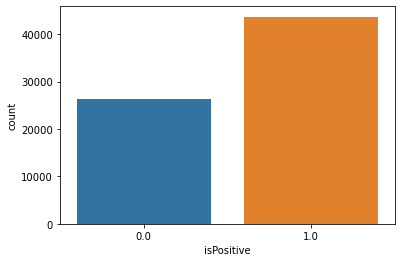

In [33]:
import seaborn as sns
sns.countplot(df['isPositive'], );

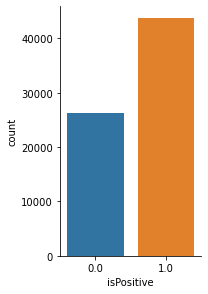

In [36]:
g = sns.catplot(x="isPositive",
                     data=df, kind="count",
                     height=4, aspect=.7);

As guessed, labels contain only two values though it has float64 as data type.

## 3. <a name="3">Text Processing: Stop words removal and stemming</a>
(<a href="#0">Go to top</a>)

In [31]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lalithap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lalithap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. 

NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [38]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# Following words can help the model to correctly test for postive and negative reviews
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# create a new stop_words list excluding the above list of words.
stop_words = [word for word in stop if word not in excluding]

# SnowballStemmer algorithm is also known as the Porter2 stemming algorithm. 
# It is almost universally accepted as better than the Porter stemmer, even being acknowledged as such by the individual who created the Porter stemmer. 
# SnowballStemmer is also more aggressive than the Porter stemmer.
snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

Now we will create a validation set.

## 4. <a name="4">Train - Validation Split</a>
(<a href="#0">Go to top</a>)

In [39]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(df[["reviewText"]],
                                                  df["isPositive"],
                                                  test_size=0.20,
                                                  shuffle=True,
                                                  random_state=42)

In [40]:
X_train

,reviewText
47339,Excellent product. Lack of details in certain ...
67456,Great I love it I need order some more
12308,worked like a charm!
32557,Very easy to use for a photography novice.
664,I've been beta testing for a few months on a l...
...,...
37194,"Easy to use, lots of variety, started immediat..."
6265,I was unable to use this product. Difficult t...
54886,"Trouble intstalling, took 3 tries."
860,The VideoStudio product tends to stay along a ...


In [41]:
y_train

47339    1.0
67456    1.0
12308    1.0
32557    1.0
664      0.0
        ... 
37194    1.0
6265     0.0
54886    0.0
860      1.0
15795    1.0
Name: isPositive, Length: 56000, dtype: float64

In [42]:
print("Processing the reviewText fields")
train_text_list = process_text(X_train["reviewText"].tolist())
val_text_list = process_text(X_val["reviewText"].tolist())

Processing the reviewText fields


In [43]:
train_text_list

['excel product lack detail certain region well updat give version map thought would up-to-d',
 'great love need order',
 'work like charm',
 'easi use photographi novic',
 "ve beta test month laptop 2.3gh hyper thread 512mb ram dedic video say miss old laptop run processor speed half ram rc1 ate resourc breakfast spit appear cool easili achiev mani program warn against buy warn hardwar market say work vista mean everyth els must dramat upgrad sinc first releas would assum take year work four releas two servic pack better worst part big brother form secur ask confirm thing mani time even log administr still grant administr right everi instal fail n't even delet someth without jump two three hoop hope n't put time bomb rc1 copi quit work long enough finish upgrad scrape major cash togeth get final copi",
 'great product',
 'use quicken quick book softwar sinc earli 1990s larg love product except quicken home busi buggi piec junk poor internet interfac android interfac constant drop pass

## 5. <a name="5">Data processing with Pipeline</a>
(<a href="#0">Go to top</a>)

Use a simple pipeline to use the text field and fit a simple K Nearest Neighbors classifier using CountVectorizer().

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
# Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# max_feature parameters may be modified
pipeline = Pipeline([('text_vect', CountVectorizer(binary=True,
                              max_features=25)),('knn', KNeighborsClassifier())  
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('text_vect', CountVectorizer(binary=True, max_features=25)),
                ('knn', KNeighborsClassifier())])

## 6. <a name="6">Train the classifier</a>
(<a href="#0">Go to top</a>)

In [52]:
X_train = train_text_list
X_val = val_text_list

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train.values)

Pipeline(steps=[('text_vect', CountVectorizer(binary=True, max_features=25)),
                ('knn', KNeighborsClassifier())])

## 7. <a name="7">Test the classifier</a>
(<a href="#0">Go to top</a>)

Let's evaluate the performance of the trained classifier. 

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted pipeline to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)
print(confusion_matrix(y_val.values, val_predictions))
print(classification_report(y_val.values, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))

[[2923 2318]
 [1932 6827]]
              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58      5241
         1.0       0.75      0.78      0.76      8759

    accuracy                           0.70     14000
   macro avg       0.67      0.67      0.67     14000
weighted avg       0.69      0.70      0.69     14000

Accuracy (validation): 0.6964285714285714


## 8. <a name="8"> Summary</a>
(<a href="#0">Go to top</a>)

The accuracy score is not bad but can improve performance with some additional work. 

- Using your validation data, try different K values and look at accuracy for them.
- Change the feature extractor to TF, TF-IDF. Also experiment with different vocabulary sizes.
- Come up with some other features such as having certain punctuations, all-capitalized words or some words that might be useful in this problem.